In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [24]:
data = pd.read_csv('../results/cleaned_data.csv')
data.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-04 21:33:40,mattrau1,1,2,0,muller_lyer_day1_illusion25.svg,Left,8.259,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
1,2024-11-04 21:33:41,jonah.harmon,1,0,0,muller_lyer_day1_illusion4.svg,Left,4.777,Group 1 - Fast,0.5,Same length,180,180,0,20,36,black,False,False
2,2024-11-04 21:33:44,mattrau1,1,2,1,muller_lyer_day1_illusion30.svg,Left,2.741,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
3,2024-11-04 21:33:45,jonah.harmon,1,0,1,muller_lyer_day1_illusion11.svg,Same length,2.907,Group 1 - Fast,0.5,Same length,205,205,0,20,36,red,False,True
4,2024-11-04 21:33:47,mwhite,1,2,0,muller_lyer_day1_illusion25.svg,Same length,3.467,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,True


In [27]:
def analyze_group_performance(df):
    # Convert is_correct to numeric (1 for True, 0 for False)
    df['is_correct_numeric'] = df['is_correct'].astype(int)
    
    # Create group identifier
    df['main_group'] = df['speed_group'].str.split(' - ').str[0]
    df['speed_condition'] = df['speed_group'].str.split(' - ').str[1]
    
    # Print data validation
    print("Data distribution across groups:")
    print(df.groupby(['main_group', 'speed_condition']).size())
    
    # Get first and last days overall
    first_day = df['day'].min()
    last_day = df['day'].max()
    
    # Filter for first and last days
    first_last_data = df[df['day'].isin([first_day, last_day])].copy()
    first_last_data['day_type'] = first_last_data['day'].map({first_day: 'First', last_day: 'Last'})
    
    # Calculate metrics for each group and condition
    metrics = []
    for group in ['Group 1', 'Group 2']:
        for speed in ['Fast', 'Slow']:
            for day_type in ['First', 'Last']:
                mask = ((first_last_data['main_group'] == group) & 
                       (first_last_data['speed_condition'] == speed) & 
                       (first_last_data['day_type'] == day_type))
                
                group_data = first_last_data[mask]
                
                if len(group_data) > 0:
                    metrics.append({
                        'main_group': group,
                        'speed_condition': speed,
                        'day_type': day_type,
                        'accuracy': group_data['is_correct_numeric'].mean(),
                        'response_time': group_data['response_time'].mean(),
                        'n_trials': len(group_data),
                        'std_accuracy': group_data['is_correct_numeric'].std(),
                        'std_rt': group_data['response_time'].std()
                    })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Statistical tests
    stats_results = {}
    for group in ['Group 1', 'Group 2']:
        group_data = first_last_data[first_last_data['main_group'] == group]
        
        # Accuracy
        first_acc = group_data[group_data['day_type'] == 'First']['is_correct_numeric']
        last_acc = group_data[group_data['day_type'] == 'Last']['is_correct_numeric']
        if len(first_acc) > 0 and len(last_acc) > 0:
            acc_ttest = stats.ttest_ind(first_acc, last_acc)
            stats_results[f'{group}_accuracy'] = acc_ttest
        
        # Response Time
        first_rt = group_data[group_data['day_type'] == 'First']['response_time']
        last_rt = group_data[group_data['day_type'] == 'Last']['response_time']
        if len(first_rt) > 0 and len(last_rt) > 0:
            rt_ttest = stats.ttest_ind(first_rt, last_rt)
            stats_results[f'{group}_rt'] = rt_ttest
    
    return {
        'metrics': metrics_df,
        'stats': stats_results,
        # 'plot': fig
    }


results = analyze_group_performance(data)

# Print results
print("\nMetrics Summary:")
print(results['metrics'])

print("\nStatistical Tests:")
for test_name, test_result in results['stats'].items():
    print(f"\n{test_name}:")
    print(f"t-statistic: {test_result.statistic:.3f}")
    print(f"p-value: {test_result.pvalue:.3f}")

Data distribution across groups:
main_group  speed_condition
Group 1     Fast               928
            Slow               880
Group 2     Fast               288
            Slow               288
dtype: int64

Metrics Summary:
  main_group speed_condition day_type  accuracy  response_time  n_trials  \
0    Group 1            Fast    First  0.193750       2.568269       160   
1    Group 1            Fast     Last  0.453125       1.833461       128   
2    Group 1            Slow    First  0.109375       3.483406       128   
3    Group 1            Slow     Last  0.484375       3.085289       128   
4    Group 2            Fast    First  0.312500       2.744271        48   
5    Group 2            Fast     Last  0.468750       2.864781        32   
6    Group 2            Slow    First  0.354167       4.675771        48   
7    Group 2            Slow     Last  0.406250       3.282062        32   

   std_accuracy    std_rt  
0      0.396476  1.324007  
1      0.499754  0.811482  

/tmp/ipykernel_191693/824899093.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_accuracy = df.groupby('diff_category')['is_correct_numeric'].agg([
/tmp/ipykernel_191693/824899093.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='length_diff_abs', y='is_correct_numeric',



Length Effect Statistics:
                mean    std  count
diff_category                     
0-5            0.266  0.443    222
6-15           0.262  0.441    126
16-25          0.534  0.500    266
26-35          0.755  0.431    282
35+              NaN    NaN      0

Length-Accuracy Correlation:
Correlation: 0.211
p-value: 0.000


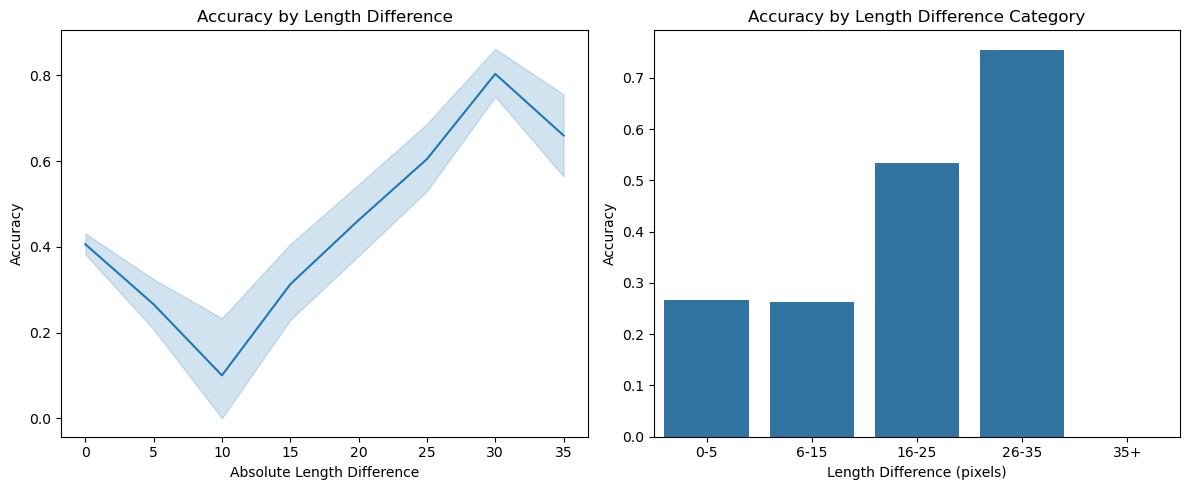

In [29]:

def analyze_arrow_length(df):
    # Convert boolean to numeric
    df['is_correct_numeric'] = df['is_correct'].astype(int)
    
    # Analysis of arrow length effect
    df['length_diff_abs'] = abs(df['actual_difference'])
    
    # Group trials by difference magnitude
    df['diff_category'] = pd.cut(df['length_diff_abs'], 
                                bins=[0, 5, 15, 25, 35, float('inf')],
                                labels=['0-5', '6-15', '16-25', '26-35', '35+'])
    
    length_accuracy = df.groupby('diff_category')['is_correct_numeric'].agg([
        'mean', 'std', 'count'
    ]).round(3)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Line plot for accuracy by length difference
    sns.lineplot(data=df, x='length_diff_abs', y='is_correct_numeric', 
                 ci=95, ax=ax1)
    ax1.set_title('Accuracy by Length Difference')
    ax1.set_xlabel('Absolute Length Difference')
    ax1.set_ylabel('Accuracy')
    
    # 2. Bar plot for categorized length differences
    sns.barplot(x=length_accuracy.index, y='mean',
                data=length_accuracy, ax=ax2)
    ax2.set_title('Accuracy by Length Difference Category')
    ax2.set_xlabel('Length Difference (pixels)')
    ax2.set_ylabel('Accuracy')
    
    plt.tight_layout()
    
    # Calculate correlation between length difference and accuracy
    length_corr = stats.pointbiserialr(df['length_diff_abs'], df['is_correct_numeric'])
    
    return {
        'length_stats': length_accuracy,
        'length_correlation': length_corr,
        'plot': fig
    }

# Example usage:
# df = pd.read_csv('cleaned_data_sample.csv')
results = analyze_arrow_length(data)

print("\nLength Effect Statistics:")
print(results['length_stats'])
print("\nLength-Accuracy Correlation:")
print(f"Correlation: {results['length_correlation'].correlation:.3f}")
print(f"p-value: {results['length_correlation'].pvalue:.3f}")

plt.show()


Color Effect Statistics:
              mean    std  count        ci
arrow_color                               
black        0.423  0.494   1192  0.028046
red          0.459  0.499   1192  0.028289

Color T-test:
t-statistic: 1.774
p-value: 0.076


/tmp/ipykernel_191693/2081508700.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='arrow_color', y='is_correct_numeric',


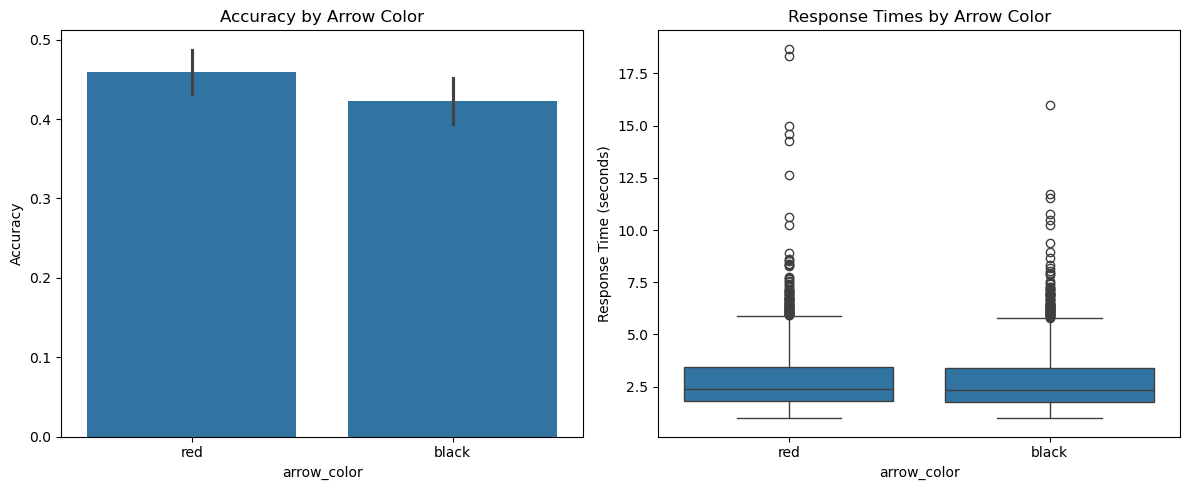

In [31]:

def analyze_arrow_color(df):
    # Convert boolean to numeric
    df['is_correct_numeric'] = df['is_correct'].astype(int)
    
    # Analysis of arrow color effects
    color_accuracy = df.groupby('arrow_color')['is_correct_numeric'].agg([
        'mean', 'std', 'count'
    ]).round(3)
    
    # Calculate confidence intervals for colors
    color_accuracy['ci'] = 1.96 * np.sqrt(
        (color_accuracy['mean'] * (1 - color_accuracy['mean'])) / color_accuracy['count']
    )
    
    # T-test for color effect
    red_trials = df[df['arrow_color'] == 'red']['is_correct_numeric']
    black_trials = df[df['arrow_color'] == 'black']['is_correct_numeric']
    color_ttest = stats.ttest_ind(red_trials, black_trials)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Bar plot for color accuracy
    sns.barplot(data=df, x='arrow_color', y='is_correct_numeric', 
                ci=95, ax=ax1)
    ax1.set_title('Accuracy by Arrow Color')
    ax1.set_ylabel('Accuracy')
    
    # 2. Boxplot for response times by color
    sns.boxplot(x='arrow_color', y='response_time', data=df, ax=ax2)
    ax2.set_title('Response Times by Arrow Color')
    ax2.set_ylabel('Response Time (seconds)')
    
    plt.tight_layout()
    
    return {
        'color_stats': color_accuracy,
        'color_ttest': color_ttest,
        'plot': fig
    }

results = analyze_arrow_color(data)

print("\nColor Effect Statistics:")
print(results['color_stats'])
print("\nColor T-test:")
print(f"t-statistic: {results['color_ttest'].statistic:.3f}")
print(f"p-value: {results['color_ttest'].pvalue:.3f}")

plt.show()